In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM, Dropout


In [2]:
# Function to fetch historical price data from Yahoo Finance
def fetch_stock_data(ticker_symbol, start_date, end_date):

    stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)
    return stock_data


In [3]:
# Define Parameters
ticker_symbol = 'MSFT'
start_date = (dt.datetime.now() - dt.timedelta(days=10*365)).strftime('%Y-%m-%d')
end_date = (dt.datetime.now() - dt.timedelta(days=1)).strftime('%Y-%m-%d')


In [4]:

# Fetch historical price data
stock_data = fetch_stock_data(ticker_symbol, start_date, end_date)
stock_data


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-05-27,40.259998,40.259998,39.810001,40.189999,34.211472,26160600
2014-05-28,40.139999,40.189999,39.820000,40.009998,34.058250,25711500
2014-05-29,40.150002,40.349998,39.910000,40.340000,34.339165,19888200
2014-05-30,40.450001,40.970001,40.250000,40.939999,34.849899,34567600
2014-06-02,40.950001,41.090000,40.680000,40.790001,34.722225,18504300
...,...,...,...,...,...,...
2024-05-13,418.010010,418.350006,410.820007,413.720001,412.975098,15440200
2024-05-14,412.019989,417.489990,411.549988,416.559998,415.809998,15109300
2024-05-15,417.899994,423.809998,417.269989,423.079987,423.079987,22239500


In [5]:
# Extracting the revalent column 'Clode'
columns_to_drop = ['Open', 'High', 'Low','Volume', 'Adj Close']
stock_data_2 = stock_data.drop(columns_to_drop, axis=1)
stock_data_2

,Close
Date,
2014-05-27,40.189999
2014-05-28,40.009998
2014-05-29,40.340000
2014-05-30,40.939999
2014-06-02,40.790001
...,...
2024-05-13,413.720001
2024-05-14,416.559998
2024-05-15,423.079987


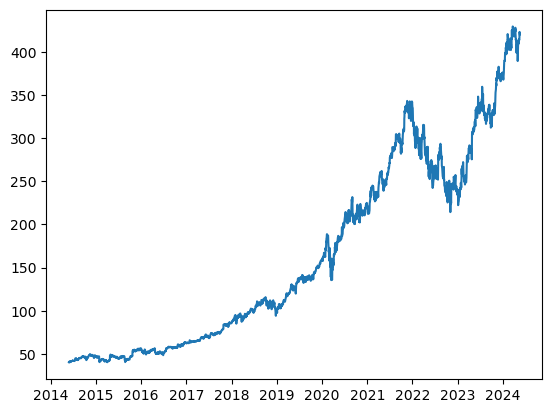

In [6]:
# Plot the stock closing price history
plt.plot(stock_data_2.index, stock_data_2['Close'])

### Note

- **Overall Trend:** The stock price has been on an upward trend over the observed period, indicating overall growth.

- **Significant Rises and Drops:** Around 2020, there is a  dip drop of the market and then followed by a strong recovery. This period might correspond to the market impacts of the COVID-19 pandemic.

In [7]:
# Function to convert string to datetime
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return dt.datetime(year=year, month=month, day=day)



In [18]:
# Function to create a windowed dataframe for LSTM input => each row corresponds to a target date and includes the closing prices from the
                                            # previous (n) days provided as features (X) and the closing price of the target date as the target (Y).
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    # Convert String Dates to Datetime Objects
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    # Initialize the target date as the first date
    target_date = first_date

    # Initialize lists to store dates, features (X), and targets (Y)
    dates = []
    X, Y = [], []

    #  indicate the last iteration
    last_time = False

    # Main loop to iterate over the target dates
    while True:
        # Extract the last n+1 rows up to the target date
        df_subset = dataframe.loc[:target_date].tail(n+1)
        
        # Check if the extracted subset is of the correct length
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        # Extract values and split into features (x) and target (y)
        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        # Append the target date, features, and target to their respective lists
        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Find the next available date that is at least one week ahead
        next_week = dataframe.loc[target_date:target_date + dt.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year, month, day = map(int, next_date_str.split('-'))
        next_date = dt.datetime(year=year, month=month, day=day)
        
        # Check if this is the last iteration
        if last_time:
            break
        
        # Update the target date to the next date
        target_date = next_date

        # Set indication that the last iteration if the target date is the last date
        if target_date == last_date:
            last_time = True
    
    # Create the return DataFrame and populate it with dates, features, and targets
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
    
    X = np.array(X)
    for i in range(0, n):
        ret_df[f'Target-{n-i}'] = X[:, i]
    
    ret_df['Target'] = Y

    return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(stock_data_2, 
                                '2021-03-25', 
                                '2022-03-23', 
                                n=3)
windowed_df


,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
247,2022-03-17,276.440002,287.149994,294.390015,295.220001
248,2022-03-18,287.149994,294.390015,295.220001,300.429993
249,2022-03-21,294.390015,295.220001,300.429993,299.160004
250,2022-03-22,295.220001,300.429993,299.160004,304.059998


In [19]:
# Function to transform the windowed dataframe into separate arrays for dates, features (X), and targets (Y)
def windowed_df_to_date_X_y(windowed_dataframe):
    # Convert the windowed dataframe to a numpy array for easier manipulation
    df_as_np = windowed_dataframe.to_numpy()

    # Extract the first column (dates) from the numpy array
    dates = df_as_np[:, 0]

    # Extract the middle columns (features) from the numpy array, excluding the first (dates) and last (target) columns
    middle_matrix = df_as_np[:, 1:-1]
    
    # Reshape the features array into the shape required for LSTM input: (number of samples, number of time steps, number of features)
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    # Extract the last column (target values) from the numpy array
    Y = df_as_np[:, -1]

    # Return the dates, features (X), and targets (Y), ensuring the features and targets are in float32 format
    return dates, X.astype(np.float32), Y.astype(np.float32)

# Convert the windowed dataframe into dates, features (X), and targets (Y)
dates, X, y = windowed_df_to_date_X_y(windowed_df)

# Display the shapes of the resulting arrays to verify the transformation
dates.shape, X.shape, y.shape


((252,), (252, 3, 1), (252,))

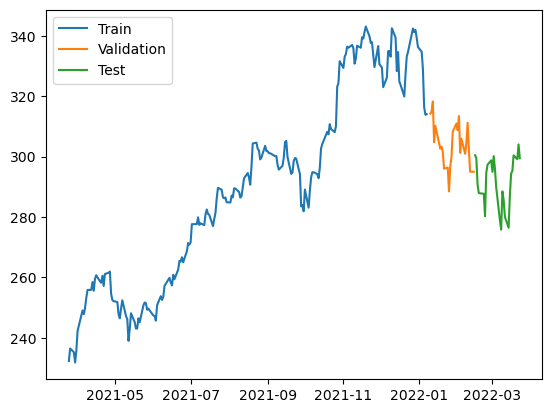

In [20]:
# Calculate the 80th percentile index for splitting the data into training and validation sets
q_80 = int(len(dates) * 0.8)

# Calculate the 90th percentile index for splitting the data into validation and test sets
q_90 = int(len(dates) * 0.9)

# Split the dates, features (X), and targets (y) into training sets using the 80th percentile index
dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

# Split the dates, features (X), and targets (y) into validation sets using the 80th to 90th percentile range
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]

# Split the dates, features (X), and targets (y) into test sets using the 90th percentile index to the end
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

# Plot the training data
plt.plot(dates_train, y_train)

# Plot the validation data
plt.plot(dates_val, y_val)

# Plot the test data
plt.plot(dates_test, y_test)

# Add a legend to differentiate between training, validation, and test data
plt.legend(['Train', 'Validation', 'Test'])


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


In [28]:
# Define the Sequential model with specified layers
model = Sequential([
    # Input layer which specifys the shape of the input data meaning that (3 time steps, 1 feature)
    layers.Input((3, 1)),
    # LSTM layer with 64 units to capture temporal dependencies
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    # Output Dense layer with 1 unit => which is now predicting the next closing price
    layers.Dense(1)
])

# Compile the model wwhere i am  specifying the loss function, optimizer, and evaluation metrics
model.compile(
    loss='mse',  # Mean Squared Error loss function for regression
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with a learning rate of 0.001
    metrics=['mean_absolute_error']  # Metric to evaluate the model performance
)

# Train the model on the training data and validate it on the validation data
model.fit(
    X_train, y_train,  # Training data (features and targets)
    validation_data=(X_val, y_val),  # Validation data (features and targets)
    epochs=80  # Number of epochs to train the model
)


Epoch 1/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - loss: 84546.8281 - mean_absolute_error: 288.9750 - val_loss: 91793.7578 - val_mean_absolute_error: 302.8874
Epoch 2/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 84797.7578 - mean_absolute_error: 289.5004 - val_loss: 91342.0625 - val_mean_absolute_error: 302.1408
Epoch 3/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 82601.4219 - mean_absolute_error: 285.7720 - val_loss: 90807.0312 - val_mean_absolute_error: 301.2541
Epoch 4/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 82325.3047 - mean_absolute_error: 285.2172 - val_loss: 90084.8594 - val_mean_absolute_error: 300.0531
Epoch 5/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 82790.8281 - mean_absolute_error: 286.2523 - val_loss: 89232.7266 - val_mean_absolute_error: 298.6298
Epoch 6/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 80513.2266 - mean_absolute_error: 281.8889 - val_loss: 88089.9375 - val_mean_absolute_error: 296.7101
Epoch 7/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/s

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


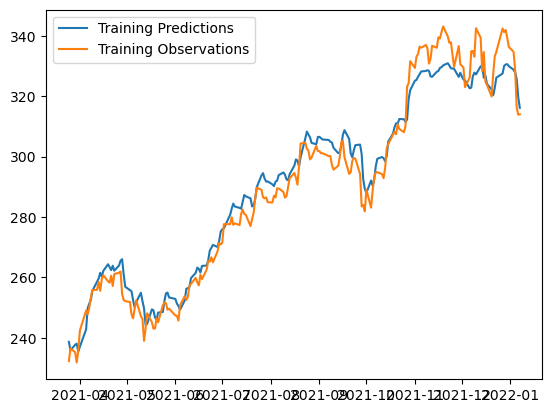

In [29]:
# make predictions on the training data using the trained model
train_predictions = model.predict(X_train).flatten()

# Plot the training predictions against the training dates
plt.plot(dates_train, train_predictions)
# Plot the actual training observations  against the training dates
plt.plot(dates_train, y_train)
# Add a legend 
plt.legend(['Training Predictions', 'Training Observations'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


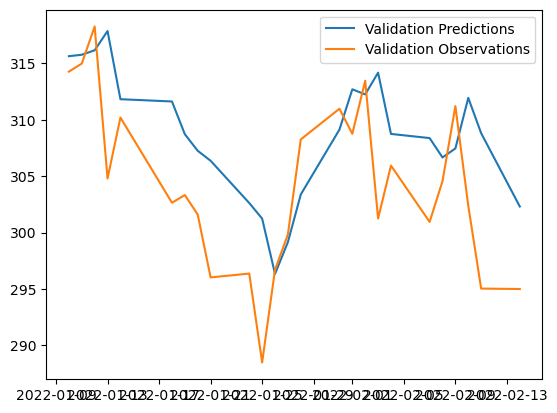

In [30]:
# make predictions on the validation data using the trained model
val_predictions = model.predict(X_val).flatten()  

# Plot the validation predictions against the validation dates
plt.plot(dates_val, val_predictions)
# Plot the actual validation observations against the validation dates
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


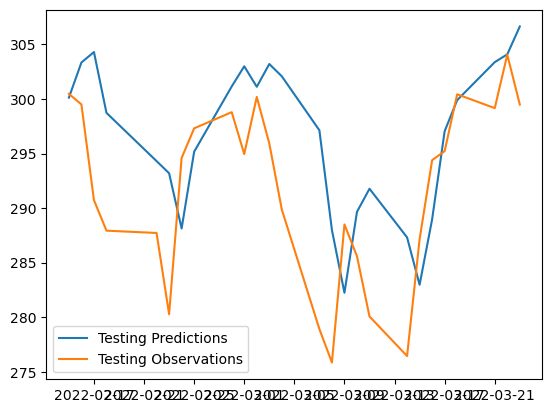

In [31]:
# make predictions on the test data using the trained model
test_predictions = model.predict(X_test).flatten()  

# Plot the test predictions against the test dates
plt.plot(dates_test, test_predictions)
# Plot the actual test observations against the test dates
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])


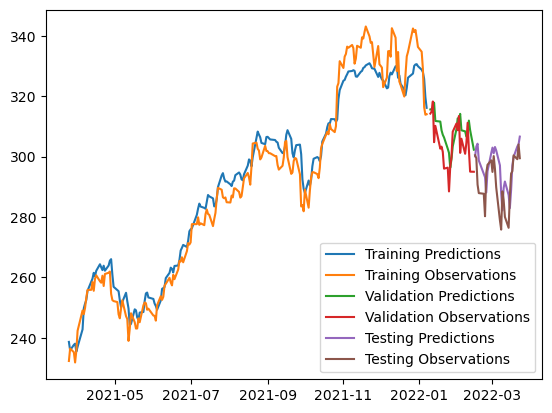

In [32]:
#Combining all the abovee three plots in one.
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])